In [32]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense


from tcn import TCN

# Inverting representations

This section introduces the computation of an approximate
inverse of a time series representation. This is formulated
as the problem of finding a time series whose representation
best matches the one given.

## I/ Representation to be inverted

### 1/ The original time-serie

In [33]:
df = pd.read_csv('all_stocks_5yr.csv', delimiter=',', usecols=['date', 'close', "Name"])
df_AAPL = df.query("Name == 'AAPL'")
df_AAPL.head(-1)

,date,close,Name
1259,2013-02-08,67.8542,AAPL
1260,2013-02-11,68.5614,AAPL
1261,2013-02-12,66.8428,AAPL
1262,2013-02-13,66.7156,AAPL
1263,2013-02-14,66.6556,AAPL
...,...,...,...
2512,2018-01-31,167.4300,AAPL
2513,2018-02-01,167.7800,AAPL
2514,2018-02-02,160.5000,AAPL
2515,2018-02-05,156.4900,AAPL


In [34]:
pd.options.plotting.backend = "plotly"
df_AAPL.plot(x='date', y='close')

In [35]:
column_indices = {name: i for i, name in enumerate(df_AAPL.columns)}

n = len(df_AAPL)
train_df = df_AAPL[0:int(n*0.7)]
val_df = df_AAPL[int(n*0.7):int(n*0.9)]
test_df = df_AAPL[int(n*0.9):]

num_features = df.shape[1]

In [36]:
close_aapl_train = train_df['close'].values
close_aapl_val = val_df['close'].values
close_aapl_test = test_df['close'].values
print("Shapes:")
print("train", close_aapl_train.shape)
print("val", close_aapl_val.shape)
print("test",close_aapl_test.shape)

Shapes:
train (881,)
val (252,)
test (126,)


### 2/ The representation (TCN)

In [37]:
import tensorflow as tf
from tensorflow import keras

In [38]:
lookback_window = 12

In [39]:
# split a univariate sequence into samples
def split_sequence(sequence, window_size):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + window_size
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [40]:
X_train, y_train = split_sequence(close_aapl_train, lookback_window)
X_val, y_val = split_sequence(close_aapl_val, lookback_window)
X_test, y_test = split_sequence(close_aapl_test, lookback_window)

In [41]:
print(X_train.shape)
print(y_train.shape)

(869, 12)
(869,)


In [51]:
i = Input(shape=(lookback_window, 1))
m = TCN()(i)
m = Dense(1, activation='linear')(m)
model = Model(inputs=[i], outputs=[m])

In [42]:
"""
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[lookback_window, 1]))
model.add(TCN())
model.add(keras.layers.Reshape((64, 1), input_shape=(64, )))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1, activation='relu', input_shape=(1, 1)))
model.add(keras.layers.AveragePooling1D(pool_size=64))
model.add(keras.layers.Reshape((1, ), input_shape=(1, 1)))
"""

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
tcn_5 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 136,321
Trainable params: 136,321
Non-trainable params: 0
_________________________________________________________________


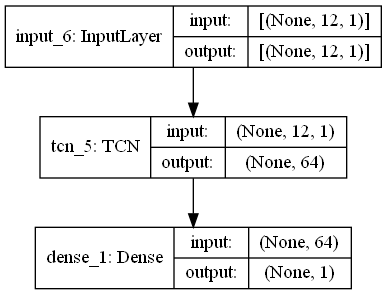

In [52]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

### 3/ The representation of the time serie

Depending on the task and type of model we may want to generate a variety of data windows. For examples:

1. For example, to make a single prediction 24 days into the future, given 24 days of history, we might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one day into the future, given six days of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

### 4/ Training the representation

In [53]:
model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

In [54]:
print('Train...')
history = model.fit(X_train,
                    y_train, 
                    epochs=100,
                    validation_data=(X_val, y_val))

Train...
Epoch 1/100
28/28 [==============================] - 3s 32ms/step - loss: 58431.6143 - mean_absolute_error: 190.1010 - val_loss: 723.0488 - val_mean_absolute_error: 26.2384
Epoch 2/100
28/28 [==============================] - 1s 20ms/step - loss: 580.7153 - mean_absolute_error: 20.3206 - val_loss: 242.5119 - val_mean_absolute_error: 14.7686
Epoch 3/100
28/28 [==============================] - 0s 18ms/step - loss: 63.3834 - mean_absolute_error: 6.3938 - val_loss: 81.0655 - val_mean_absolute_error: 8.0372
Epoch 4/100
28/28 [==============================] - 1s 20ms/step - loss: 31.5908 - mean_absolute_error: 4.5604 - val_loss: 27.7640 - val_mean_absolute_error: 4.1625
Epoch 5/100
28/28 [==============================] - 0s 18ms/step - loss: 22.0431 - mean_absolute_error: 3.6892 - val_loss: 22.6788 - val_mean_absolute_error: 3.6736
Epoch 6/100
28/28 [==============================] - 1s 18ms/step - loss: 21.4327 - mean_absolute_error: 3.5937 - val_loss: 43.7523 - val_mean_absolut

In [55]:
import matplotlib.pyplot as plt

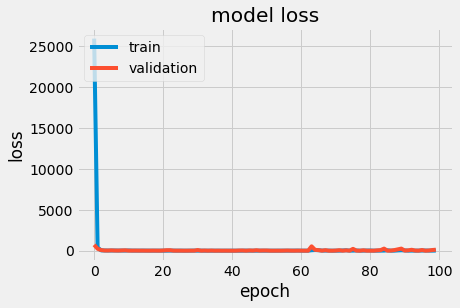

In [56]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [57]:
predict = model.predict(X_test)

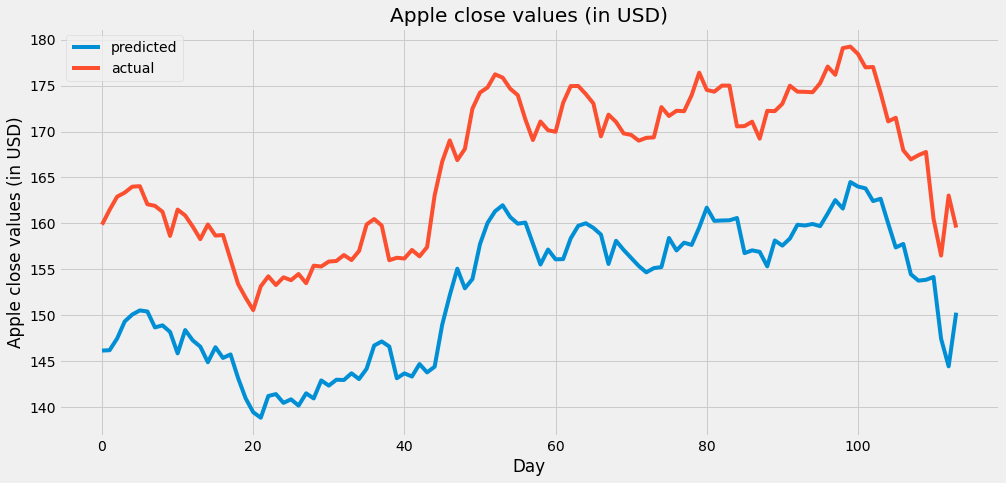

In [58]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,7))
plt.plot(predict)
plt.plot(y_test)
plt.title('Apple close values (in USD)')
plt.legend(['predicted', 'actual'])
plt.xlabel("Day")
plt.ylabel("Apple close values (in USD)")
plt.show()

### Inversion

Let's try to inverse an encodage of a time serie by the representation. For example:

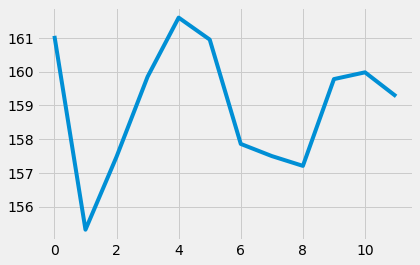

In [59]:
pre_expected_ts = X_test[0]
plt.plot(pre_expected_ts)

### 3/ Loss function

In [ ]:
def loss(preds, target):
    mse = tf.keras.losses.MeanSquaredError()
    return mse(target, preds).numpy()

### 4/ Regulariser

In [ ]:
def regulariser(x, alpha):
    return np.linalg.norm(x, alpha)

## II/ Optimisation